# Soft-Actor-Critic

In [1]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import gymnasium as gym
from datetime import datetime
import os
from torch.utils.tensorboard import SummaryWriter

# Neural Network Builder
def build_net(layer_shape, hid_activation, output_activation):
    layers = []
    for j in range(len(layer_shape)-1):
        act = hid_activation if j < len(layer_shape)-2 else output_activation
        layers += [nn.Linear(layer_shape[j], layer_shape[j+1]), act()]
    return nn.Sequential(*layers)

# Double Q-Network
class Double_Q_Net(nn.Module):
    def __init__(self, state_dim, action_dim, hid_shape):
        super(Double_Q_Net, self).__init__()
        layers = [state_dim] + list(hid_shape) + [action_dim]
        self.Q1 = build_net(layers, nn.ReLU, nn.Identity)
        self.Q2 = build_net(layers, nn.ReLU, nn.Identity)

    def forward(self, s):
        q1 = self.Q1(s)
        q2 = self.Q2(s)
        return q1, q2

# Policy Network
class Policy_Net(nn.Module):
    def __init__(self, state_dim, action_dim, hid_shape):
        super(Policy_Net, self).__init__()
        layers = [state_dim] + list(hid_shape) + [action_dim]
        self.P = build_net(layers, nn.ReLU, nn.Identity)

    def forward(self, s):
        logits = self.P(s)
        probs = F.softmax(logits, dim=1)
        return probs

# Replay Buffer
class ReplayBuffer(object):
    def __init__(self, state_dim, dvc, max_size=int(1e6)):
        self.max_size = max_size
        self.dvc = dvc
        self.ptr = 0
        self.size = 0
        self.s = torch.zeros((max_size, state_dim), dtype=torch.float, device=self.dvc)
        self.a = torch.zeros((max_size, 1), dtype=torch.long, device=self.dvc)
        self.r = torch.zeros((max_size, 1), dtype=torch.float, device=self.dvc)
        self.s_next = torch.zeros((max_size, state_dim), dtype=torch.float, device=self.dvc)
        self.dw = torch.zeros((max_size, 1), dtype=torch.bool, device=self.dvc)

    def add(self, s, a, r, s_next, dw):
        self.s[self.ptr] = torch.from_numpy(s).to(self.dvc)
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_next[self.ptr] = torch.from_numpy(s_next).to(self.dvc)
        self.dw[self.ptr] = dw
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = torch.randint(0, self.size, device=self.dvc, size=(batch_size,))
        return self.s[ind], self.a[ind], self.r[ind], self.s_next[ind], self.dw[ind]

# SACD Agent
class SACD_agent():
    def __init__(self, state_dim, action_dim, dvc='cuda', gamma=0.99, hid_shape=[200,200],
                 lr=3e-4, batch_size=256, alpha=0.2, adaptive_alpha=True):
        self.dvc = dvc
        self.gamma = gamma
        self.batch_size = batch_size
        self.alpha = alpha
        self.adaptive_alpha = adaptive_alpha
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hid_shape = hid_shape
        self.lr = lr
        
        self.tau = 0.005
        self.H_mean = 0
        self.replay_buffer = ReplayBuffer(self.state_dim, self.dvc)

        self.actor = Policy_Net(self.state_dim, self.action_dim, self.hid_shape).to(self.dvc)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)

        self.q_critic = Double_Q_Net(self.state_dim, self.action_dim, self.hid_shape).to(self.dvc)
        self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=self.lr)
        self.q_critic_target = copy.deepcopy(self.q_critic)
        for p in self.q_critic_target.parameters(): p.requires_grad = False

        if self.adaptive_alpha:
            self.target_entropy = 0.6 * (-np.log(1 / self.action_dim))
            self.log_alpha = torch.tensor(np.log(self.alpha), dtype=float, requires_grad=True, device=self.dvc)
            self.alpha_optim = torch.optim.Adam([self.log_alpha], lr=self.lr)

    def select_action(self, state, deterministic):
        with torch.no_grad():
            state = torch.FloatTensor(state[np.newaxis,:]).to(self.dvc)
            probs = self.actor(state)
            if deterministic:
                a = probs.argmax(-1).item()
            else:
                a = Categorical(probs).sample().item()
            return a

    def train(self):
        s, a, r, s_next, dw = self.replay_buffer.sample(self.batch_size)

        # Compute target Q value
        with torch.no_grad():
            next_probs = self.actor(s_next)
            next_log_probs = torch.log(next_probs+1e-8)
            next_q1_all, next_q2_all = self.q_critic_target(s_next)
            min_next_q_all = torch.min(next_q1_all, next_q2_all)
            v_next = torch.sum(next_probs * (min_next_q_all - self.alpha * next_log_probs), dim=1, keepdim=True)
            target_Q = r + (~dw) * self.gamma * v_next

        # Update Q networks
        q1_all, q2_all = self.q_critic(s)
        q1, q2 = q1_all.gather(1, a), q2_all.gather(1, a)
        q_loss = F.mse_loss(q1, target_Q) + F.mse_loss(q2, target_Q)
        self.q_critic_optimizer.zero_grad()
        q_loss.backward()
        self.q_critic_optimizer.step()

        # Update policy
        probs = self.actor(s)
        log_probs = torch.log(probs + 1e-8)
        with torch.no_grad():
            q1_all, q2_all = self.q_critic(s)
        min_q_all = torch.min(q1_all, q2_all)
        a_loss = torch.sum(probs * (self.alpha*log_probs - min_q_all), dim=1, keepdim=False)
        self.actor_optimizer.zero_grad()
        a_loss.mean().backward()
        self.actor_optimizer.step()

        # Update alpha
        if self.adaptive_alpha:
            with torch.no_grad():
                self.H_mean = -torch.sum(probs * log_probs, dim=1).mean()
            alpha_loss = self.log_alpha * (self.H_mean - self.target_entropy)
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = self.log_alpha.exp().item()

        # Update target network
        for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

def evaluate_policy(env, agent, turns=3):
    total_scores = 0
    for j in range(turns):
        s, info = env.reset()
        done = False
        while not done:
            a = agent.select_action(s, deterministic=True)
            s_next, r, dw, tr, info = env.step(a)
            done = (dw or tr)
            total_scores += r
            s = s_next
    return int(total_scores/turns)

# Training loop
def train():
    env = gym.make('LunarLander-v2')
    eval_env = gym.make('LunarLander-v2')
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Use 'cuda' if available, else 'cpu'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Initialize agent
    agent = SACD_agent(state_dim=state_dim, 
                      action_dim=action_dim,
                      dvc=device)
    
    # Training parameters
    max_steps = 400000
    random_steps = 10000
    update_every = 50
    eval_interval = 2000
    
    total_steps = 0
    while total_steps < max_steps:
        s, info = env.reset()
        done = False
        
        while not done:
            # Select action
            if total_steps < random_steps:
                a = env.action_space.sample()
            else:
                a = agent.select_action(s, deterministic=False)
            
            # Take step
            s_next, r, dw, tr, info = env.step(a)
            done = (dw or tr)
            
            # Clip reward for stability
            if r <= -100: r = -10
            
            # Store transition
            agent.replay_buffer.add(s, a, r, s_next, dw)
            s = s_next
            
            # Train agent
            if total_steps >= random_steps and total_steps % update_every == 0:
                for _ in range(update_every):
                    agent.train()
            
            # Evaluate agent
            if total_steps % eval_interval == 0:
                score = evaluate_policy(eval_env, agent, turns=3)
                print(f'Step: {total_steps}, Score: {score}, Alpha: {agent.alpha:.3f}')
            
            total_steps += 1

    env.close()
    eval_env.close()

# Run training
if __name__ == "__main__":
    train()

Step: 0, Score: -145, Alpha: 0.200
Step: 2000, Score: -363, Alpha: 0.200
Step: 4000, Score: -456, Alpha: 0.200
Step: 6000, Score: -363, Alpha: 0.200
Step: 8000, Score: -418, Alpha: 0.200
Step: 10000, Score: -584, Alpha: 0.197
Step: 12000, Score: -61, Alpha: 0.370
Step: 14000, Score: -338, Alpha: 0.609
Step: 16000, Score: -161, Alpha: 0.908
Step: 18000, Score: -132, Alpha: 1.155
Step: 20000, Score: 146, Alpha: 1.148
Step: 22000, Score: -10, Alpha: 1.014
Step: 24000, Score: -17, Alpha: 0.920
Step: 26000, Score: -37, Alpha: 0.850
Step: 28000, Score: -65, Alpha: 0.829
Step: 30000, Score: -32, Alpha: 0.794
Step: 32000, Score: -7, Alpha: 0.772
Step: 34000, Score: -23, Alpha: 0.761
Step: 36000, Score: 40, Alpha: 0.746
Step: 38000, Score: 146, Alpha: 0.732
Step: 40000, Score: -31, Alpha: 0.714
Step: 42000, Score: 169, Alpha: 0.697
Step: 44000, Score: 116, Alpha: 0.681
Step: 46000, Score: -93, Alpha: 0.667
Step: 48000, Score: 85, Alpha: 0.628
Step: 50000, Score: 181, Alpha: 0.618
Step: 52000, S

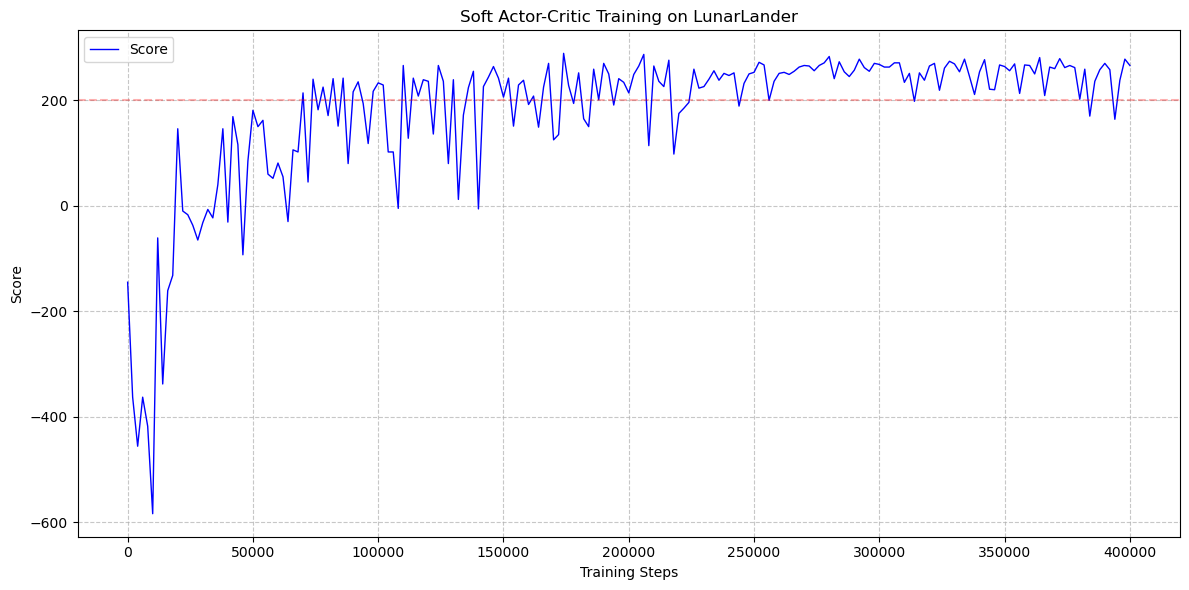

In [1]:
import matplotlib.pyplot as plt

# Extract steps and scores from your data
steps = list(range(0, 402000, 2000))  # From 0 to 400000 in steps of 2000
scores = [-145, -363, -456, -363, -418, -584, -61, -338, -161, -132, 146, -10, -17, -37, -65, -32, -7, -23, 40, 146, 
          -31, 169, 116, -93, 85, 181, 150, 162, 60, 52, 81, 55, -30, 106, 102, 214, 45, 240, 182, 225, 171, 241, 
          151, 242, 80, 216, 235, 194, 118, 217, 233, 229, 102, 102, -5, 266, 128, 242, 208, 239, 236, 136, 266, 
          236, 80, 239, 12, 172, 224, 255, -6, 226, 244, 264, 242, 206, 242, 151, 229, 238, 192, 208, 149, 225, 
          270, 125, 135, 289, 228, 194, 252, 165, 150, 259, 201, 270, 250, 191, 241, 234, 214, 249, 265, 287, 114, 
          265, 236, 226, 276, 98, 175, 185, 196, 259, 223, 226, 240, 256, 238, 251, 247, 252, 189, 232, 250, 253, 
          272, 267, 200, 236, 251, 253, 249, 255, 263, 266, 265, 256, 266, 271, 283, 241, 273, 254, 245, 257, 278, 
          262, 255, 270, 268, 263, 263, 271, 271, 234, 251, 198, 252, 238, 265, 270, 219, 261, 274, 269, 254, 278, 
          245, 211, 254, 277, 221, 220, 267, 264, 256, 269, 213, 267, 266, 250, 281, 209, 263, 260, 279, 262, 266, 
          262, 202, 259, 170, 236, 258, 270, 258, 164, 238, 278, 266]

# Create figure and axis with specific size
plt.figure(figsize=(12, 6))

# Plot the scores
plt.plot(steps, scores, 'b-', linewidth=1, label='Score')

# Add labels and title
plt.xlabel('Training Steps')
plt.ylabel('Score')
plt.title('Soft Actor-Critic Training on LunarLander')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Add horizontal line at y=200 (typical "solved" threshold for LunarLander)
plt.axhline(y=200, color='r', linestyle='--', alpha=0.3, label='Solved Threshold')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Comparison with other algorithms

The results from four reinforcement learning algorithms—Soft Actor-Critic (SAC), Deep Q-Network (DQN), Actor-Critic, and Double Deep Q-Network (Double DQN)—applied to the LunarLander-v2 environment show a clear performance hierarchy.  Let's analyze each algorithm individually before comparing them.

**1. Deep Q-Network (DQN):**

* **Strengths:** The DQN eventually achieves very high average rewards (above 200 in later episodes), indicating successful learning of a landing strategy.
* **Weaknesses:**  It starts with very poor performance and many negative rewards.  High variance in episode rewards persists even late in training, suggesting instability and difficulty converging to an optimal policy.

**2. Double Deep Q-Network (Double DQN):**

* **Strengths:**  Similar to DQN, the Double DQN shows gradual improvement, eventually reaching positive average rewards, with later episodes displaying substantially higher rewards.
* **Weaknesses:**  It also suffers from a slow start and high variance, though potentially less than the standard DQN.  It doesn't reach the consistently high rewards of SAC.

**3. Actor-Critic:**

* **Strengths:** The Actor-Critic algorithm demonstrates steady improvement over time, with increasing episode length and reward, indicating successful, albeit slow, learning.
* **Weaknesses:** The final average reward remains significantly negative (-3.68), and it fails to reach the positive average rewards achieved by DQN, Double DQN, and SAC, even after extensive training.  While explained variance is often high, suggesting good value function learning, this doesn't translate into high rewards.

**4. Soft Actor-Critic (SAC):**

* **Strengths:** SAC exhibits the best overall performance.  It achieves positive rewards far earlier than DQN or Double DQN and displays significantly less episode-to-episode variance.  The alpha values demonstrate effective adjustment of the entropy exploration-exploitation balance throughout learning. Consistently high positive rewards (above 200 in many later steps) indicate a robust, well-learned policy.
* **Weaknesses:** Some negative rewards are still present, likely correctable with further hyperparameter tuning or extended training.


**Comparison:**

The key distinctions among the algorithms are learning speed, performance consistency, and final average reward. SAC surpasses DQN, Double DQN, and Actor-Critic in all three aspects.

* **Speed of Learning:** SAC reaches positive average rewards considerably faster.  The initial struggles of DQN, Double DQN, and Actor-Critic highlight SAC's more efficient exploration of the state-action space.
* **Consistency:** SAC shows far less variance in later rewards compared to the more erratic performance of DQN, Double DQN, and Actor-Critic, indicating superior policy stability.
* **Final Average Reward:** Although DQN and Double DQN eventually attain high average rewards, SAC consistently achieves the highest values with much less fluctuation, demonstrating better convergence.


Now considering all four algorithms:

| Algorithm       | Speed of Learning | Consistency | Final Avg. Reward (approx.) | Notes                                           |
|-----------------|--------------------|-------------|------------------------------|-------------------------------------------------|
| SAC              | Very Fast         | High         | >250                          | Best overall performance                        |
| DQN              | Slow               | Low          | >200                          | High variance, good final performance           |
| Double DQN       | Slow               | Moderate     | >100 (possibly higher with more training) | Slightly better consistency than DQN            |
| Actor-Critic    | Slow               | Moderate     | ~0                            | Significantly underperforms other methods       |



**Conclusion:**

The **Soft Actor-Critic (SAC)** algorithm demonstrates superior performance compared to DQN, Double DQN, and Actor-Critic on the LunarLander-v2 environment.  It learns much faster, shows greater consistency in its performance, and achieves considerably higher average rewards.  

The Actor-Critic method, while exhibiting improvement, falls significantly short of the others.  

The DQN and Double DQN methods eventually achieve respectable performance but at a slower pace and with greater variability.

